In [3]:
!pip install git+https://github.com/boudinfl/pke.git
!pip install langdetect
!pip install polars
!pip install groq
!pip install pyarrow
!pip install fastparquet

  Cloning https://github.com/boudinfl/pke.git to c:\users\xavmo\appdata\local\temp\pip-req-build-3xzlbzha
  Resolved https://github.com/boudinfl/pke.git to commit 69871ffdb720b83df23684fea53ec8776fd87e63
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/boudinfl/pke.git 'C:\Users\xavmo\AppData\Local\Temp\pip-req-build-3xzlbzha'


In [3]:
# Librairies nécessaires
import numpy as np
import requests
import pandas as pd
import polars as pl
from langdetect import detect
import json
import tqdm
from tqdm import trange

import unicodedata
import re

## Importation d'un corpus : 

Sorbonne Université à tous son corpus de publications principalement sur HAL.  
Cependant, suite à une annonce de partenariat avec OpenAlex et allant de plus en plus sur cette bibliothèque gratuite et open source, le choix d'aller chercher dans un premier temps mon corpus dessus est donc le plus pertinant.  
Dans un premier temps, il nous faut donc comparer la différence des mots clés utilisés dans HAL et OpenAlex via le travail de Nacef effectué sur le github suivant (https://github.com/obtic-sorbonne/keywords/blob/main/TER_Keyword_Extraction_sur_BDD_HAL.ipynb).  
Regardons un premier temps quelles sont les métadonnées des publications sur HAL et OA en prenant pour exemple une publication de Stephane Le Crom

In [2]:
import requests
import json

hal_id = 'hal-00122816'
url = f"https://api.archives-ouvertes.fr/search/?q=halId_s:{hal_id}&wt=json"

response = requests.get(url)
# Faire la requête à l'API
if response.status_code == 200:
    
    # Conversion de la réponse en JSON
    data = json.loads(response.text)
    # Prendre le premier document (s'il y en a plusieurs)
    doc = data['response']['docs'][0]
    print(doc)
    # Vérifier s'il y a des documents dans la réponse
    if data['response']['numFound'] > 0:
        
        # Afficher les noms de toutes les métadonnées
        for key in doc.keys():
            print(key)
    else:
        print("Aucune publication trouvée avec cet identifiant HAL.")
else:
    print(f"Erreur lors de la requête : {response.status_code}")

{'docid': '122816', 'label_s': 'Marika Kapsimali, Stéphane Le Crom, Philippe Vernier. A natural history of vertebrate dopamine receptors.. Anita Sidhu, Marc Laruelle, Philippe Vernier. Dopamine Receptors and Transporters, Marcel Dekker Inc, pp.1-45, 2003. &#x27E8;hal-00122816&#x27E9;', 'uri_s': 'https://hal.science/hal-00122816'}
docid
label_s
uri_s


In [24]:
# ID de l'auteur
author_id = "a5007814380"  

# URL de l'API
url = f"https://api.openalex.org/works?filter=author.id:{author_id}"

# Faire la requête à l'API
response = requests.get(url)

# Vérifier que la requête a réussi
if response.status_code == 200:
    
    # Conversion de la réponse en JSON
    data = json.loads(response.text)
    print(data.keys())
    i=1
    for work in data['results'] : 
        if i==1 :
            print(work.keys())
            i+=1

dict_keys(['meta', 'results', 'group_by'])
dict_keys(['id', 'doi', 'title', 'display_name', 'publication_year', 'publication_date', 'ids', 'language', 'primary_location', 'type', 'type_crossref', 'indexed_in', 'open_access', 'authorships', 'countries_distinct_count', 'institutions_distinct_count', 'corresponding_author_ids', 'corresponding_institution_ids', 'apc_list', 'apc_paid', 'fwci', 'has_fulltext', 'cited_by_count', 'cited_by_percentile_year', 'biblio', 'is_retracted', 'is_paratext', 'primary_topic', 'topics', 'keywords', 'concepts', 'mesh', 'locations_count', 'locations', 'best_oa_location', 'sustainable_development_goals', 'grants', 'datasets', 'versions', 'referenced_works_count', 'referenced_works', 'related_works', 'ngrams_url', 'abstract_inverted_index', 'cited_by_api_url', 'counts_by_year', 'updated_date', 'created_date'])


  On voit qu'il nous ait bien compliqué d'obtenir par code tous les paramètres des métadonnées d'une publication sur HAL. Je vous encourage donc à suivre
le lien suivant afin de mieux comprendre les différents paramètres renseignés initialement (https://hal.science/help/information).  
Nous remarquons à présent avec la seconde brique de code tous les différents paramètres renseignés par les métadonnées d'une publication d'OpenAlex. Celles-ci sont nettement plus complexes et intéressantes à utiliser que celles de HAL, et ce pour de multiples raisons :  
- <ins>**Keywords et scorings**</ins> :  Keywords choisis par Bert, en fonction d'un scoring indiqué. </br> 
</br> 
- <ins>**Topics**</ins> : Le topics d'OpenAlex ont été créés manuellement et les publications y sont classées par clustering ( pour plus de renseignement je vous encourage à lire le document suivant mise en ligne par OA: https://docs.google.com/document/d/1bDopkhuGieQ4F8gGNj7sEc8WSE8mvLZS/edit#heading=h.5w2tb5fcg77r) </br>
</br>
-  <ins>**Citations** </ins> : OA est la seule librairie en ligne où il y a la présence des références dans les métadonnées, c'est-à-dire à la fois les travaux qui le référence ou à contrario qu'il référence. Cela est d'une grande aide pour faire la liaison entre ces différents travaux. Cet ajout permet de faciliter la récupération des citation et donc d'appliquer l'algorithme de Leiden plus aisément.</br> 

Dans un premier temps, une étude des keywords en fonction d'HAL et d'OpenAlex sera faite afin de verifier la pertinence de leurs attributions. Pour ce
faire, nous appliquerons un raisonnement par induction. Nous sélectionnerons un plus petit corpus constitué des travaux de Stéphane Le Crom afin d'obtenir des premiers résultats rapides. Puis, nous appliquerons notre protocole sur notre corpus global pour une comparaison à plus grande échelle.

### Quel protocole utiliser ?

In [6]:
# test a deux lvl pour keywords -> mots clés exacts similaires ou etymologiquement similaire (via du LLM ou scoring ??)
#                               -> comparaison par topic de ses mots clés d'open alex (Comparaison avec les autres topics??)
#                               -> comment calculer la similarité? calculer par mbert

### I/ Récupération des publications de Stéphane Le Crom sur HAL et OpenAlex

In [50]:
auteurs = ["Stéphane Le Crom"]

# Initialisez une liste vide pour stocker les métadonnées des publications
publications = []

# URL de base de l'API HAL
base_url = "https://api.archives-ouvertes.fr/search/"

# Parcourez la liste des auteurs et récupérez leurs publications
for auteur in auteurs:
    params = {
        "q": f'authFullName_s:"{auteur}"',
        "fl": "authFullName_s,authIdHal_i,authIdHal_s,title_s,halId_s,producedDateY_i,doiId_s,abstract_s,uri_s,domain_s,keyword_s",
        "rows": 10000  # Augmentez le nombre de lignes si nécessaire
    }

    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        publications.extend(data["response"]["docs"])
    else:
        print(f"Erreur pour l'auteur {auteur}: {response.status_code} - {response.text}")

# Créez un DataFrame Pandas à partir des métadonnées des publications
column_order = ["authFullName_s", "authIdHal_i", "authIdHal_s", "title_s", "halId_s", "producedDateY_i", "doiId_s", "keyword_s", "abstract_s", "uri_s", "domain_s"]

df = pd.DataFrame(publications, columns= column_order)

# Sauvegardez le DataFrame dans un fichier CSV
df.to_csv("publications_hal_stephane_le_crom.csv", index=False)

# Affichez le nombre total de publications récupérées
print(f"Nombre total de publications récupérées : {len(df)}")

Nombre total de publications récupérées : 64


In [51]:
# Conversion les listes en chaînes dans la colonne "title_s"
df["title_s"] = df["title_s"].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Suppression des doublons à base du titre seulement
df = df.drop_duplicates(subset="title_s")
print(f"Publications restantes après nettoyage : {len(df)}")

Publications restantes après nettoyage : 62


In [33]:
# ID de l'auteur
author_id = "a5052835091"

# URL de l'API
url = f"https://api.openalex.org/works?filter=author.id:{author_id}&per-page=200"

# Faire la requête à l'API
response = requests.get(url)

# Vérifier que la requête a réussi
if response.status_code == 200:
    # Conversion de la réponse en JSON
    data = json.loads(response.text)

    # Sélection les métadonnées précises
    selected_data = []
    
    for work in data['results']:
        
        author_ids = []
        if 'authorships' in work: 
            for authorship in work['authorships']:
                # Ajoutez l'identifiant de l'auteur à la liste 'author_ids'
                author_ids.append(authorship["author"]["id"])
                
        keywords, scorings = [], [] 
        if 'keywords' in work:
            for id in work['keywords']:
                keywords.append(id['display_name'])
                scorings.append(id['score'])
                
        selected_data.append({
            'id' : work['id'],
            'doi': work['doi'],
            'title': work['title'],
            'authors_id' : author_ids, 
            'keywords' : keywords, 
            'scorings' : scorings,
            'referenced_works': work['referenced_works'], 
            'related_works': work['related_works'],
            'cited_by_api_url': work['cited_by_api_url'],    
        })

    # Conversion des données sélectionnées en DataFrame
    df2 = pd.DataFrame(selected_data)

    # Exportation du DataFrame en CSV
    df2.to_csv('publications_oa_stephane_le_crom.csv', index=False)
else:
    print(f"Erreur : {response.status_code}")

### Nettoyage et liaison des corpus : 

Les publications ont été prélevés sur HAL et OA, il faut donc les lier entre elles afin de pouvoir les comparer efficacement. A ça, deux solutions possibles :  
- <ins>**Par le titre**</ins> : le plus évident mais que des points négatifs. Le code pour nettoyer un titre est conséquent (comme on peut le voir dans le bloc suivant, inspiré de celui d'openalex). Parmi tous ces points négatifs, on peut y trouver la différence de langue pour une même publication, l'apparition de caractères non latin, ...  
<br>
- <ins>**Par le DOI**</ins> : Le DOI est unique pour chaque publication quelque soit l'endroit où il est posté. Cela présente donc la meilleure solution pour lier les documents. Pour effectuer cette tache au mieux, il faut nettoyer le DOI des publications d'OA. Celui-ci est un lien composer d'un début de requête API suivi du DOI. Nous devons donc faire en sorte de ne conserver que le DOI. De plus, nous supprimerons dans le dataset de HAL toutes les publications sans DOI ainsi que les dupliquer.

In [8]:
def name_to_keep_ind(groups):
    """
    Function to determine if a text should be kept or not.

    Input:
    groups: list of character groups

    Output:
    0: if text should be not used
    1: if text should be used
    """
    # Groups of characters that do not perform well
    groups_to_skip = ['HIRAGANA', 'CJK', 'KATAKANA','ARABIC', 'HANGUL', 'THAI','DEVANAGARI','BENGALI',
                      'THAANA','GUJARATI','CYRILLIC']
    
    if any(x in groups_to_skip for x in groups):
        return 0
    else:
        return 1

def remove_non_latin_characters(text):
    """
    Function to remove non-latin characters.

    Input:
    text: string of characters

    Output:
    final_char: string of characters with non-latin characters removed
    """
    final_char = []
    groups_to_skip = ['HIRAGANA', 'CJK', 'KATAKANA','ARABIC', 'HANGUL', 'THAI','DEVANAGARI','BENGALI',
                      'THAANA','GUJARATI','CYRILLIC']
    for char in text:
        try:
            script = unicodedata.name(char).split(" ")[0]
            if script not in groups_to_skip:
                final_char.append(char)
        except:
            pass
    return "".join(final_char)
    
def group_non_latin_characters(text):
    """
    Function to group non-latin characters and return the number of latin characters.

    Input:
    text: string of characters

    Output:
    groups: list of character groups
    latin_chars: number of latin characters
    """
    groups = []
    latin_chars = []
    text = text.replace(".", "").replace(" ", "")
    for char in text:
        try:
            script = unicodedata.name(char).split(" ")[0]
            if script == 'LATIN':
                latin_chars.append(script)
            else:
                if script not in groups:
                    groups.append(script)
        except:
            if "UNK" not in groups:
                groups.append("UNK")
    return groups, len(latin_chars)

def check_for_non_latin_characters(text):
    """
    Function to check if non-latin characters are dominant in a text.

    Input:
    text: string of characters

    Output:
    0: if text should be not used
    1: if text should be used
    """
    groups, latin_chars = group_non_latin_characters(str(text))
    if name_to_keep_ind(groups) == 1:
        return 1
    elif latin_chars > 20:
        return 1
    else:
        return 0

def clean_title(old_title):
    """
    Function to check if title should be kept and then remove non-latin characters. Also
    removes some HTML tags from the title.
    
    Input:
    old_title: string of title
    
    Output:
    new_title: string of title with non-latin characters and HTML tags removed
    """
    keep_title = check_for_non_latin_characters(old_title)
    if (keep_title == 1) & isinstance(old_title, str):
        new_title = remove_non_latin_characters(old_title)
        if '<' in new_title:
            new_title = new_title.replace("<i>", "").replace("</i>","")\
                                 .replace("<sub>", "").replace("</sub>","") \
                                 .replace("<sup>", "").replace("</sup>","") \
                                 .replace("<em>", "").replace("</em>","") \
                                 .replace("<b>", "").replace("</b>","") \
                                 .replace("<I>", "").replace("</I>", "") \
                                 .replace("<SUB>", "").replace("</SUB>", "") \
                                 .replace("<scp>", "").replace("</scp>", "") \
                                 .replace("<font>", "").replace("</font>", "") \
                                 .replace("<inf>","").replace("</inf>", "") \
                                 .replace("<i /> ", "") \
                                 .replace("<p>", "").replace("</p>","") \
                                 .replace("<![CDATA[<B>", "").replace("</B>]]>", "") \
                                 .replace("<italic>", "").replace("</italic>","")\
                                 .replace("<title>", "").replace("</title>", "") \
                                 .replace("<br>", "").replace("</br>","").replace("<br/>","") \
                                 .replace("<B>", "").replace("</B>", "") \
                                 .replace("<em>", "").replace("</em>", "") \
                                 .replace("<BR>", "").replace("</BR>", "") \
                                 .replace("<title>", "").replace("</title>", "") \
                                 .replace("<strong>", "").replace("</strong>", "") \
                                 .replace("<formula>", "").replace("</formula>", "") \
                                 .replace("<roman>", "").replace("</roman>", "") \
                                 .replace("<SUP>", "").replace("</SUP>", "") \
                                 .replace("<SSUP>", "").replace("</SSUP>", "") \
                                 .replace("<sc>", "").replace("</sc>", "") \
                                 .replace("<subtitle>", "").replace("</subtitle>", "") \
                                 .replace("<emph/>", "").replace("<emph>", "").replace("</emph>", "") \
                                 .replace("""<p class="Body">""", "") \
                                 .replace("<TITLE>", "").replace("</TITLE>", "") \
                                 .replace("<sub />", "").replace("<sub/>", "") \
                                 .replace("<mi>", "").replace("</mi>", "") \
                                 .replace("<bold>", "").replace("</bold>", "") \
                                 .replace("<mtext>", "").replace("</mtext>", "") \
                                 .replace("<msub>", "").replace("</msub>", "") \
                                 .replace("<mrow>", "").replace("</mrow>", "") \
                                 .replace("</mfenced>", "").replace("</math>", "")

            if '<mml' in new_title:
                all_parts = [x for y in [i.split("mml:math>") for i in new_title.split("<mml:math")] for x in y if x]
                final_parts = []
                for part in all_parts:
                    if re.search(r"\>[$%#!^*\w.,/()+-]*\<", part):
                        pull_out = re.findall(r"\>[$%#!^*\w.,/()+-]*\<", part)
                        final_pieces = []
                        for piece in pull_out:
                            final_pieces.append(piece.replace(">", "").replace("<", ""))
                        
                        final_parts.append(" "+ "".join(final_pieces) + " ")
                    else:
                        final_parts.append(part)
                
                new_title = "".join(final_parts).strip()
            else:
                pass

            if '<xref' in new_title:
                new_title = re.sub(r"\<xref[^/]*\/xref\>", "", new_title)

            if '<inline-formula' in new_title:
                new_title = re.sub(r"\<inline-formula[^/]*\/inline-formula\>", "", new_title)

            if '<title' in new_title:
                new_title = re.sub(r"\<title[^/]*\/title\>", "", new_title)

            if '<p class=' in new_title:
                new_title = re.sub(r"\<p class=[^>]*\>", "", new_title)
            
            if '<span class=' in new_title:
                new_title = re.sub(r"\<span class=[^>]*\>", "", new_title)

            if 'mfenced open' in new_title:
                new_title = re.sub(r"\<mfenced open=[^>]*\>", "", new_title)
            
            if 'math xmlns' in new_title:
                new_title = re.sub(r"\<math xmlns=[^>]*\>", "", new_title)

        if '<' in new_title:
            new_title = new_title.replace(">i<", "").replace(">/i<", "") \
                                 .replace(">b<", "").replace(">/b<", "") \
                                 .replace("<inline-formula>", "").replace("</inline-formula>","")
        if new_title.isupper():
            new_title = new_title.title()
        
        return new_title
    else:
        return ''
    
def liaison_second(df1_hal, df2_oa):
    # On clean les titres de la df d'OpenAlex
    for i, title in enumerate(df2_oa['title']):
        new_title = clean_title(title)  # clean_title : la fonction de nettoyage appropriée
        df2_oa.loc[i, 'title'] = new_title

    # On convertit les titres d'oa en liste
    list_oa_title = df2_oa['title'].tolist()

    # On supprime toutes les publications qui ne sont pas en commun
    indexes_to_drop = []
    for i, title in enumerate(df1_hal['title_s']):
        if title not in list_oa_title:
            indexes_to_drop.append(i)

    df1_hal.drop(indexes_to_drop, inplace=True)
    
def clean_doi_oa(old_doi):
    if old_doi is not None:
        return old_doi.replace("https://doi.org/", "")
    else:
        return None

def clean_doi_oa2(df):
    df.dropna(subset=['doi'], inplace=True)
    df.drop_duplicates(subset=['doi'], inplace=True)
    
def clean_doi_hal(df):
    df.dropna(subset=['doiId_s'], inplace=True)
    df.drop_duplicates(subset=['doiId_s'], inplace=True)

def liaison(df1_hal, df2_oa, all):
    
    # On clean les DOI de la df d'OpenAlex
    for i, doi in enumerate(df2_oa['doi']):
        new_doi = clean_doi_oa(doi)
        df2_oa.loc[i, 'doi'] = new_doi
    
    # On convertit les DOI d'HAL en liste
    list_hal_doi = df1_hal['doiId_s'].tolist()
    
    # Création de la nouvelle df de stockage
    df2_change = pd.DataFrame()

    # On supprime toutes les publications qui ne sont pas en commun
    indexes_to_drop = []
    
    for i, doi in enumerate(df2_oa['doi']):
        if doi in list_hal_doi:
            index_in_df1_hal = df1_hal[df1_hal['doiId_s'] == doi].index[0]
            df2_change = pd.concat([df2_change, df1_hal.loc[[index_in_df1_hal]]])
        else : 
            indexes_to_drop.append(i)
     
    df2_oa.drop(indexes_to_drop, errors='ignore', inplace=True)
    if all == True : 
        df2_change.to_csv('pub_hal_liees_all_corpus.csv', index=False)
    if all == False : 
        df2_change.to_csv('pub_hal_liees_crom.csv', index=False)
    
    return df2_change

Nous allons lier les publications de OpenAlex et de Hal par le DOI. Pour ce faire, un nettoyage du DOI est nécessaire.

Dans les deux corpus, nous supprimons les publications qui n’ont pas de DOI ainsi que celles qui apparaissent en double, en ne conservant qu’une seule occurrence. Cependant, pour OpenAlex, le DOI apparaît sous la forme https://doi.org/10.1002/nme.2859. Nous utiliserons l’algorithme clean_doi_oa pour transformer ce format en 10.1002/nme.2859.

Cette étape de nettoyage présente plusieurs avantages :

1. **Uniformité** : En standardisant le format des DOI, nous facilitons les comparaisons et les liens entre les publications.
2. **Précision** : En éliminant les doublons et les publications sans DOI, nous améliorons la qualité et la fiabilité des données.
3. **Efficacité** : Le processus de nettoyage permet de simplifier et d’accélérer les étapes suivantes de l’analyse.

In [54]:
print("-----------------------")
print("----- Clean df oa -----")
print("-----------------------")
print(df2.shape)
clean_doi_oa2(df2)
print(df2.shape)
print("-----------------------")
print("---- Clean df HAL -----")
print("-----------------------")
print(df.shape)
clean_doi_hal(df)
print(df.shape)


-----------------------
----- Clean df oa -----
-----------------------
(94, 9)
(77, 9)
-----------------------
---- Clean df HAL -----
-----------------------
(62, 11)
(47, 11)


In [55]:
print("Vérification de l'unicité de chaque DOI de HAL")
is_all_unique_hal = df['doiId_s'].nunique() == len(df['doiId_s'])
print(is_all_unique_hal)
print("---------------------------------------------")
print("Vérification de l'unicité de chaque DOI de OA")
is_all_unique_oa = df2['doi'].nunique() == len(df2['doi'])
print(is_all_unique_oa)

Vérification de l'unicité de chaque DOI de HAL
True
---------------------------------------------
Vérification de l'unicité de chaque DOI de OA
True


In [56]:
df2_change = liaison(df,df2)
print(len(df2_change))

44


Nous pouvons remarquer à présent que nos algorithmes de nettoyage ont bien fonctionné. Le corpus de Hal est passé de 94 à 77 et celui d'open alex de 62 à 47. Après vérification que tous les DOIs de chaque corpus, la liaison a pu être effective par la suite créant ainsi un corpus unique et lié de 44 documents. Cela montre dans le même temps que la quasi totalité des publications de HAL étaient également présentes dans Open Alex.  
<br>
Une fois la création du corpus effectué, nous pouvons passer à l'étape de la comparaison des mots clés entre ceux choisis par LLAMA et ceux mis par Open Alex. Pour cela, comme indiqué précedemment, nous passerons par l'api de Grocq afin de pouvoir créer des keywords par llama et ensuite nous les comparerons à ceux d'open alex par mBert

### Passage par LLama et comparaison par mBert : 

In [65]:
import os
from groq import Groq

os.environ["GROQ_API_KEY"] = "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"

client = Groq(
    api_key=os.environ.get("GROQ_API_KEY"),
)

def extract_keywords_groq(text, models):
    prompt = f"As a keyword extraction master, your only mission here is to extract only the most relevent keywords that are present in the text. Put the list of keywords between brackets, comma-seperated.DO NOT write something else than the keywords you're supposed to extract from the text. Skip the preamble and provide only the best keywords (present in the text). The text:\n{text} VERY IMPORTANT : Put the list of keywords between brackets, comma-seperated like this ['keyword1', 'keyword2, 'keyword3' etc...] NO TICKS only what ive said"
    chat_completion = client.chat.completions.create(
    messages=[

            {
                "role": "user",
                "content": prompt,
            },
            {
                "role": "assistant",
                "content": "["
            }
        ],
        model=models,
        max_tokens=1024
    )
    response = chat_completion.choices[0].message.content
    keyword_list = [keyword.strip(' "') for keyword in response.strip("[]").split(', ')]


    return keyword_list

def extract_groq(df, list_models, use_title = False):
    
    for model in list_models :

        list_kw = []

        for row in trange(len(df)):
            text = df.loc[row,'abstract_s']
            if pd.isnull(text):
                text = ''
            else:
                text = str(text)
                
            if use_title:
                title = df.loc[row, 'title_s']
                if not pd.isnull(title):
                    text += str(title)
                    
            kw = extract_keywords_groq(text, model)
            list_kw.append(kw)
            
        list_of_dicts = [{'list of kw': keywords} for keywords in list_kw]
        df_kw = pl.DataFrame(list_of_dicts)

        df[model] = df_kw['list of kw']
    
    return df


In [58]:
models = ['llama3-8b-8192',
          "llama3-70b-8192"]

df = pd.read_csv('pub_hal_liees.csv')

df_llm = extract_groq(df, models)
df_llm_title = extract_groq(df_llm, models, use_title = True)

100%|██████████| 44/44 [02:36<00:00,  3.55s/it]


In [66]:
models = ['llama3-8b-8192',
          "llama3-70b-8192"]

In [59]:
df_llm_title.to_csv('pub_hal_liees_keywords.csv', index=True)
df_llm_title.head()

,authFullName_s,authIdHal_i,authIdHal_s,title_s,halId_s,producedDateY_i,doiId_s,keyword_s,abstract_s,uri_s,domain_s,llama3-8b-8192,llama3-70b-8192
0,"['Marie-Agnès Dillies', 'Andrea Rau', 'Julie A...","[746907, 744212, 15356, 743285, 918596, 759094...","['marie-agnes-dillies', 'andrea-rau', 'julie-a...",A comprehensive evaluation of normalization me...,hal-00782486,2012,10.1093/bib/bbs046,"['High-throughput sequencing', 'Differential a...","['During the last 3 years, a number of approac...",https://inria.hal.science/hal-00782486,"['0.stat', '1.stat.ap', '0.sdv', '0.sdv', '1.s...","[rna sequencing, normalization, data analysis,...","[RNA sequencing, normalization, differential a..."
1,"['Christian Kubicek', 'Alfredo Herrera-Estrell...","[919336, 937936, 937937, 937933, 937934, 83334...",['stephane-le-crom'],Comparative genome sequence analysis underscor...,hal-02879334,2011,10.1186/gb-2011-12-4-r40,NaN,"['Background: Mycoparasitism, a lifestyle wher...",https://hal.sorbonne-universite.fr/hal-02879334,"['0.sdv', '1.sdv.mp', '2.sdv.mp.myc', '0.sdv',...","[Mycoparasitism, Trichoderma, Fungus, Plant pa...","[Mycoparasitism, Trichoderma, Hypocrea, Biocon..."
2,"['Sylvia Ginés', 'Joëlle Hillion', 'Maria Torv...","[13760, 748114]","['stephane-le-crom', 'philippe-vernier']",Dopamine D1 and adenosine A1 receptors form fu...,hal-00122183,2000,10.1073/pnas.150241097,NaN,['The possible molecular basis for the previou...,https://hal.science/hal-00122183,"['0.sdv', '1.sdv.neu']","[A1R, D1R, Adenosine, Dopamine, Receptors, Het...","[Adenosine A1 receptors, Dopamine D1 receptors..."
3,"['Lea Atanasova', 'Stéphane Le Crom', 'Sabine ...","[937933, 13760, 937934, 937935, 937936, 919336...",['stephane-le-crom'],Comparative transcriptomics reveals different ...,inserm-00799174,2013,10.1186/1471-2164-14-121,"['Hypocrea', 'T atroviride', 'T virens', 'T re...",['ABSTRACT: BACKGROUND: Trichoderma is a genus...,https://inserm.hal.science/inserm-00799174,"['0.sdv', '1.sdv.bbm', '2.sdv.bbm.gtp']","[Trichoderma, mycoparasitism, fungal diseases,...","[Trichoderma, mycoparasitism, biocontrol, fung..."
4,"['Thomas Portnoy', 'Antoine Margeot', 'Rita Li...","[919326, 919327, 919328, 919329, 919330, 91933...",['stephane-le-crom'],The CRE1 carbon catabolite repressor of the fu...,inserm-00663944,2011,10.1186/1471-2164-12-269,NaN,['BACKGROUND: The identification and character...,https://inserm.hal.science/inserm-00663944,"['0.sdv', '1.sdv.bbm', '2.sdv.bbm.gtp']","[Carbon catabolite repression, gene targets, t...","[carbon catabolite repression, CreA, CRE1, Tri..."


Une fois les mots-clés attribués par LLama, nous procédons à une comparaison sémantique des mots à l’aide de mBert. Il est préférable d’utiliser mBert plutôt que Bert car certains mots ou documents peuvent être en anglais. mBert permet de réaliser cette comparaison malgré tout, même si cela peut parfois entraîner une légère baisse de qualité dans le résultat.

L’utilisation de mBert présente plusieurs avantages :

1. **Multilinguisme** : mBert est conçu pour gérer plusieurs langues, ce qui le rend plus adapté aux contextes multilingues.
2. **Robustesse** : Même si la qualité peut légèrement diminuer, mBert offre une robustesse accrue dans les comparaisons sémantiques entre différentes langues.
3. **Adaptabilité** : mBert peut être utilisé dans divers domaines et pour différents types de documents, augmentant ainsi la flexibilité de l’algorithme.

In [71]:
import torch
from transformers import BertModel, BertTokenizer
from scipy.spatial.distance import cosine

# Chargez le modèle et le tokenizer BERT pré-entraînés
model = BertModel.from_pretrained('bert-base-multilingual-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

c:\Users\xavmo\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [72]:
print("---------------------------------------------")
print("------------- Un exemple --------------------")
print("---------------------------------------------\n")

# Encodez les groupes de mots en tant que vecteurs BERT
input_ids1 = tokenizer.encode("je t'aime", add_special_tokens=True)
input_ids2 = tokenizer.encode("je t'aime", add_special_tokens=True)

# Transformez les listes en tenseurs PyTorch et ajoutez une dimension supplémentaire
input_ids1 = torch.tensor([input_ids1])
input_ids2 = torch.tensor([input_ids2])

# Obtenez les sorties du modèle
outputs1 = model(input_ids1)
outputs2 = model(input_ids2)

# Les vecteurs de mots sont les dernières représentations cachées
word_vectors1 = outputs1.last_hidden_state
word_vectors2 = outputs2.last_hidden_state

# Calculez les vecteurs moyens pour chaque groupe de mots
mean_vector1 = torch.mean(word_vectors1, dim=1)
mean_vector2 = torch.mean(word_vectors2, dim=1)

# Supprimez les dimensions de taille 1
mean_vector1 = mean_vector1.squeeze()
mean_vector2 = mean_vector2.squeeze()

# Calculez la similarité cosinus entre les deux vecteurs moyens
similarity = 1 - cosine(mean_vector1.detach().numpy(), mean_vector2.detach().numpy())

print(f"La similarité entre 'je t'aime' et 'je t'aime' est {similarity}")

---------------------------------------------
------------- Un exemple --------------------
---------------------------------------------

La similarité entre 'je t'aime' et 'je t'aime' est 1.0


In [144]:
def comparaison_list(list_oa, list_hal):
    
    dico = {}
    list_scor = []
    
    #pour que chaque mot est une attribution, il faut commencer par la plus grande liste 

    
    for i in list_oa:
        
        list_scor = []
        
        for j in list_hal: 
            
            # Encodez les groupes de mots en tant que vecteurs BERT
            input_ids1 = tokenizer.encode(i, add_special_tokens=True)
            input_ids2 = tokenizer.encode(j, add_special_tokens=True)

            # Transformez les listes en tenseurs PyTorch et ajoutez une dimension supplémentaire
            input_ids1 = torch.tensor([input_ids1])
            input_ids2 = torch.tensor([input_ids2])

            # Obtenez les sorties du modèle
            outputs1 = model(input_ids1)
            outputs2 = model(input_ids2)

            # Les vecteurs de mots sont les dernières représentations cachées
            word_vectors1 = outputs1.last_hidden_state
            word_vectors2 = outputs2.last_hidden_state

            # Calculez les vecteurs moyens pour chaque groupe de mots
            mean_vector1 = torch.mean(word_vectors1, dim=1)
            mean_vector2 = torch.mean(word_vectors2, dim=1)

            # Supprimez les dimensions de taille 1
            mean_vector1 = mean_vector1.squeeze()
            mean_vector2 = mean_vector2.squeeze()

            # Calculez la similarité cosinus entre les deux vecteurs moyens
            similarity = 1 - cosine(mean_vector1.detach().numpy(), mean_vector2.detach().numpy())
            list_scor.append(similarity)
            
        #erreur ici  si je fais par taille de liste -> donc ajouter un if else
        dico[i] = (list_hal[list_scor.index(max(list_scor))], max(list_scor))  
    
    return dico
        

In [142]:
print("---------------------------------------------")
print("------------- Un exemple --------------------")
print("---------------------------------------------\n")
res = comparaison_list(['je t aime', 'je te haie', 'trouver la voie', 'stage obtic'], ['je t aime', 'je te haie', 'trouver un chemin', 'bienvenue à l obtic'])
print(res)

---------------------------------------------
------------- Un exemple --------------------
---------------------------------------------

{'je t aime': ('je t aime', 1.0), 'je te haie': ('je te haie', 1.0), 'trouver la voie': ('trouver un chemin', 0.8881398594930151), 'stage obtic': ('bienvenue à l obtic', 0.6975156987190868)}


Comme nous pouvons le constater à travers les divers exemples, mBert est bien fonctionnel et il est parfaitement adapté à notre algorithme. Cet algorithme permet d’associer à chaque élément d’une liste le meilleur mot-clé de la seconde liste mise en paramètre.

Le résultat est donc structuré sous forme d’un dictionnaire, où chaque mot-clé de la première liste est associé à un tuple contenant le mot-clé correspondant de la seconde liste ainsi que le score d’association. Par exemple :

 - { kw1 : (kw associé, score), kw2 : (kw associé, score), …}  

Cette méthode présente plusieurs avantages :

1. **Précision** : Grâce à mBert, les associations sont plus précises et pertinentes.
2. **Efficacité** : Le format dictionnaire permet une récupération rapide et facile des associations.
3. **Flexibilité** : L’algorithme peut être adapté à différentes tailles de listes et à divers domaines d’application.

In [196]:
from itertools import zip_longest

def scorings_kw(df1_hal, df2_oa, model):
    
    new_colomn = []

    # Comparaison des listes avec zip_longest
    for i, j in zip_longest(df2_oa['keywords'], df1_hal[model], fillvalue=None):
        res = comparaison_list(i, j)
        new_colomn.append(res)

    # Ajouter la nouvelle colonne au DataFrame
    name_column = 'Comparatif ' + model
    df2_oa[name_column] = new_colomn
    
    return df2_oa


In [65]:
result = scorings_kw(df_llm_title, df2, 'llama3-8b-8192' )

Voici deux exemples montrant l'efficacité de la comparaison : 

In [115]:
result.iloc[42]

authFullName_s               ['Sylvia Ginés', 'Joëlle Hillion', 'Maria Torv...
authIdHal_i                                                    [13760, 748114]
authIdHal_s                           ['stephane-le-crom', 'philippe-vernier']
title_s                      Dopamine D1 and adenosine A1 receptors form fu...
halId_s                                                           hal-00122183
producedDateY_i                                                           2000
doiId_s                                                 10.1073/pnas.150241097
keyword_s                                                                  NaN
abstract_s                   ['The possible molecular basis for the previou...
uri_s                                         https://hal.science/hal-00122183
domain_s                                                ['0.sdv', '1.sdv.neu']
llama3-8b-8192               [A1R, D1R, Adenosine, Dopamine, Receptors, Het...
llama3-70b-8192              [Adenosine A1 receptors

In [117]:
compa = result['Comparatif llama3-8b-8192']
compa[2]

{'Dopamine': ('Dopamine', 1.0),
 'Adenosine Receptors': ('Adenosine', 0.8061946210438079)}

### Statistiques : 

Pour un plus grand approfondissement, nous allons étudier les moyennes et les écarts-types des scores des différentes publications du corpus.

Cette analyse statistique nous permettra de comprendre la distribution. En effet, en calculant la moyenne, nous obtenons une idée générale des scores typiques des publications. Cela nous aide également à évaluer la variabilité grâce à l’écart-type qui nous indique à quel point les scores varient autour de la moyenne, ce qui peut révéler des disparités importantes entre les publications et ainsi identifier les anomalies en portant un regard sur les publications avec des scores très éloignés de la moyenne.

In [1]:
def mean_std(dico) :
    
    res = []
    
    for key , value in dico.items():
        res.append(value[1])
    return np.std(res), np.mean(res) 
    
def list_mean_std(colonne) :
    
    list_std ,list_mean = [], []
    
    for i in colonne :
        # On esquive les listes nulles à cause des keywords d'oa absents
        if i == {}:
            pass
        else : 
            std, mean = mean_std(i)
            list_std.append(std)
            list_mean.append(mean)
        
    return list_std ,list_mean

In [161]:
liste_std_crom, list_mean_crom = list_mean_std(result['Comparatif llama3-8b-8192'])

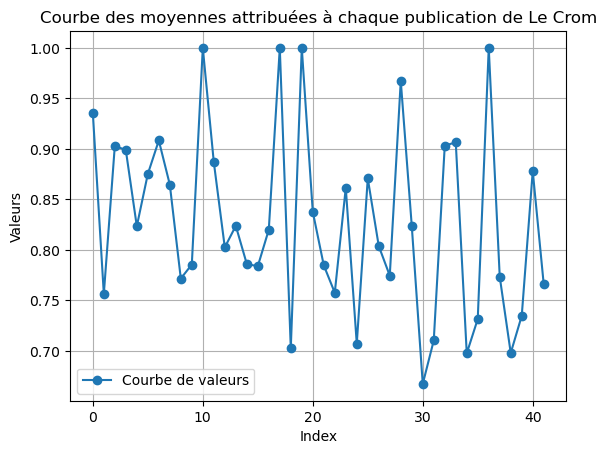

In [164]:
import matplotlib.pyplot as plt

# Création du graphique
plt.plot(list_mean_crom, marker='o', label='Courbe des moyennes')
plt.xlabel('Index')
plt.ylabel('Valeurs')
plt.title('Courbe des moyennes attribuées à chaque publication de Le Crom')
plt.grid(True)
plt.legend()
plt.show()

Comme nous pouvons le constater dans ce premier graphe, les valeurs oscillent entre 0,67 et 1. C’est un très bon signe, car cela indique que les mots-clés attribués par OpenAlex et par LLama sont assez similaires. Cela démontre la pertinence du système d’OpenAlex.

Étudier les résultats à l’aide d’une courbe de Gauss nous permettra de mieux comprendre la distribution des scores et d’identifier les tendances générales ainsi que les anomalies potentielles. Cela nous aidera à évaluer la cohérence et la fiabilité des mots-clés attribués par OpenAlex et LLama.

Dans la première figure, nous avons tenté de calculer la moyenne en utilisant la moyenne des scores de chaque publication, et l’écart-type en utilisant la moyenne de tous les écarts-types. Cependant, nous remarquons que la courbe qui en résulte n’est pas correcte, car cette méthode ne prend pas en compte la variabilité individuelle des scores. En effet, en utilisant une moyenne des écarts-types, nous perdons des informations cruciales sur la dispersion des données spécifiques à chaque publication. Cela peut entraîner une sous-estimation ou une surestimation de la variabilité réelle des scores, rendant la courbe moins représentative de la distribution réelle des données.

Pour obtenir une courbe plus précise, il serait préférable de calculer la moyenne et l’écart-type de manière plus rigoureuse, en tenant compte de la distribution complète des scores de chaque publication. C'est pour cette raison que pour la seconde courbe nous avons décidé de se baser seulement sur la liste des moyennes des scores et d'en tirer une moyenne et un écart-type

La deuxième courbe de Gauss en revanche  montre mieux la distribution des valeurs des mots-clés attribués par OpenAlex et LLama. Voici quelques observations :

1. **Distribution des valeurs** : Les valeurs oscillent entre 0,65 et 1, avec une concentration plus élevée autour de 0,85. Cela indique que la majorité des mots-clés attribués sont très similaires.
2. **Forme de la courbe** : La courbe de Gauss montre une distribution normale, ce qui suggère que les écarts par rapport à la moyenne sont symétriques et que les valeurs extrêmes sont rares.
3. **Densité** : La densité des valeurs est plus élevée autour de la moyenne, ce qui renforce l’idée que les mots-clés attribués par OpenAlex et LLama sont généralement cohérents.
En résumé, cette courbe de Gauss montre que les mots-clés attribués par OpenAlex et LLama sont globalement similaires, ce qui valide la pertinence de votre système.

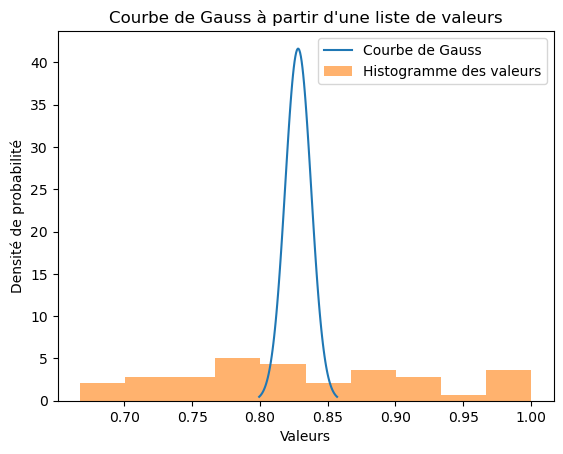

In [175]:
# Calcul de la moyenne et de l'écart-type
moyenne = np.mean(list_mean_crom)
ecart_type = np.mean(liste_std_crom)

# Création d'une distribution normale
x = np.linspace(moyenne - 3 * ecart_type, moyenne + 3 * ecart_type, 100)
y = (1 / (ecart_type * np.sqrt(2 * np.pi))) * np.exp(-(x - moyenne)**2 / (2 * ecart_type**2))

# Affichage de la courbe de Gauss
plt.plot(x, y, label='Courbe de Gauss')
plt.hist(list_mean_crom, bins=10, density=True, alpha=0.6, label='Histogramme des valeurs') 
plt.xlabel('Valeurs')
plt.ylabel('Densité de probabilité')
plt.title('Courbe de Gauss à partir d\'une liste de valeurs')
plt.legend()
plt.show()

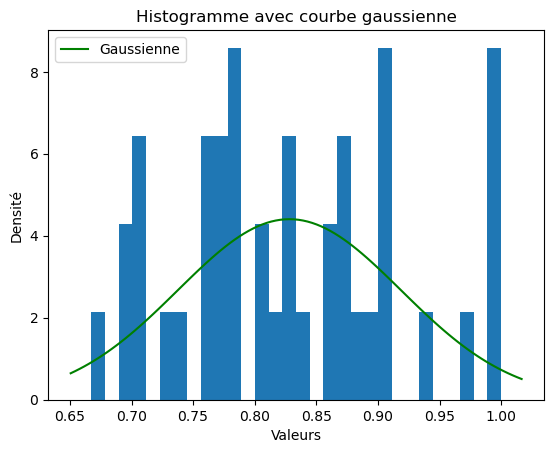

In [180]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


# Histogramme
plt.hist(list_mean_crom, bins=30, density=True)

# Courbe gaussienne
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, np.mean(list_mean_crom), np.std(list_mean_crom))
plt.plot(x, y, color='green', label='Gaussienne')

plt.xlabel('Valeurs')
plt.ylabel('Densité')
plt.title('Histogramme avec courbe gaussienne')
plt.legend()
plt.show()

## II/ Test sur tout le corpus 

### Récupération du corpus de HAL et d'OA et leur nettoyage : 

In [185]:
# Script de Waly modifié.
# Liste des noms d'auteurs que vous souhaitez rechercher
auteurs_hal = [
    "Anne-Virginie Salsac",
    "Dan Istrate",
    "Eric Leclerc",
    "Julien \"Le Duigou\"",
    "Marie-Christine \"Ho Ba Tho\"",
    "Sofiane Boudaoud",
    "Glenn Roe",
    "Motasem ALRAHABI",
    "Arnaud Latil",
    "Christian NERI",
    "Clément Mabi",
    "David Flacher",
    "M. Shawky",
    "Serge Bouchardon",
    "Harry Sokol",
    "Bérangère Bihan-Avalle",
    "Caroline Marti",
    "Laurent Petit",
    "Pierre-Carl Langlais",
    "David Klatzmann",
    "Raphael Gavazzi",
    "Benjamin Wandelt",
    "christophe pichon",
    "Guilhem Lavaux",
    "Henry Joy McCracken",
    "Kumiko Kotera",
    "Yohan Dubois",
    "A. Marco Saitta",
    "Dirk Stratmann",
    "Guillaume Ferlat",
    "Slavica Jonic",
    "Alex Chin",
    "Fabrice Carrat",
    "Pierre-Yves Boëlle",
    "Renaud Piarroux",
    "Christophe Guillotel-Nothmann",
    "Jean-Marc Chouvel",
    "Nicolas Obin",
    "Philippe Esling",
    "Alexandre Coninx",
    "Baptiste Caramiaux",
    "Benjamin Piwowarski",
    "Catherine Achard",
    "Catherine Pelachaud",
    "Gilles Bailly",
    "Jérôme Szewczyk",
    "Kevin Bailly",
    "Laure Soulier",
    "Marie-Aude Vitrani",
    "Matthieu Cord",
    "Mehdi Khamassi",
    "Mohamed CHETOUANI",
    "Nathanaël Jarrassé",
    "Nicolas Bredeche",
    "Nicolas Perrin-Gilbert",
    "Nicolas Thome",
    "Olivier Schwander",
    "Olivier Sigaud",
    "Pascal Morin",
    "Pierre Bessière",
    "Sinan Haliyo",
    "Stéphane Doncieux",
    "Alessandra Carbone",
    "Elodie Laine",
    "Martin Weigt",
    "Benoit Semelin",
    "Emeric Bron",
    "Emmanuel Bertin",
    "Françoise Combes",
    "Maryvonne Gerin",
    "Philippe Salomé",
    "Baptiste Cecconi",
    "Philippe Zarka",
    "Ferdinand Dhombres",
    "Jean Charlet",
    "Xavier Tannier",
    "Amal \"El Fallah Seghrouchni\"",
    "Andrea Pinna",
    "Antoine Miné",
    "Béatrice Bérard",
    "Bertrand Granado",
    "Bruno Escoffier",
    "Carola Doerr",
    "Christoph Dürr",
    "Christophe Denis",
    "Christophe Marsala",
    "Colette Faucher",
    "Emmanuel HYON",
    "Emmanuelle Encrenaz-Tiphène",
    "Evripidis Bampis",
    "Fanny Pascual",
    "Haralampos Stratigopoulos",
    "Jean-Daniel Kant",
    "Jean-Gabriel Ganascia",
    "Jean-Noël Vittaut",
    "Lionel Tabourier",
    "Maria Potop-Butucaru",
    "Matthieu Latapy",
    "Nicolas MAUDET",
    "Olivier Spanjaard",
    "Patrice Perny",
    "Patrick Gallinari",
    "Sébastien Tixeuil",
    "Spyros Angelopoulos",
    "Stéphane Gançarski",
    "Vanda Luengo",
    "Vincent Guigue",
    "Bruno Despres",
    "Frédéric Nataf",
    "Julien Brajard",
    "Sylvie Thiria",
    "Catherine Matias",
    "Charlotte Dion-Blanc",
    "Claire Boyer",
    "Gérard Biau",
    "Gregory Nuel",
    "Idris Kharroubi",
    "Maud Thomas",
    "Maxime Sangnier",
    "Olivier Lopez",
    "Sylvain Le-Corff",
    "Tabea Rebafka",
    "Benjamin Fuks",
    "Stéphane Mottelet",
    "Tien-Tuan Dao",
    "julien mozziconacci",
    "Nicolas Aunai",
    "Thierry Dufour",
    "Abdenour Hadid",
    "Benjamin Quost",
    "Bruno Toupance",
    "Dominique Lenne",
    "Evelyne Heyer",
    "Franz Manni",
    "Grace Younes",
    "Lama Tarsissi",
    "Marie-Hélène (Mylène) Masson",
    "Marie-Hélène Abel",
    "Nathalie Martial-Braz",
    "Nicolas Patin",
    "Philippe Bonnifait",
    "Philippe Boulanger",
    "Philippe Trigano",
    "Raed Abu Zitar",
    "Samuel F. Feng",
    "Sébastien Destercke",
    "Tanujit Chakraborty",
    "Yves Grandvalet",
    "Zoheir ABOURA"
]

# Initialisez une liste vide pour stocker les métadonnées des publications
publications = []

# URL de base de l'API HAL
base_url = "https://api.archives-ouvertes.fr/search/"

# Parcourez la liste des auteurs et récupérez leurs publications
for auteur in auteurs_hal:
    params = {
        "q": f'authFullName_s:"{auteur}"',
        "fl": "authFullName_s,authIdHal_i,authIdHal_s,title_s,halId_s,producedDateY_i,doiId_s,abstract_s,uri_s,domain_s,keyword_s",
        "rows": 10000  # Augmentez le nombre de lignes si nécessaire
    }

    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        publications.extend(data["response"]["docs"])
    else:
        print(f"Erreur pour l'auteur {auteur}: {response.status_code} - {response.text}")

# Créez un DataFrame Pandas à partir des métadonnées des publications
column_order = ["authFullName_s", "authIdHal_i", "authIdHal_s", "title_s", "halId_s", "producedDateY_i", "doiId_s", "keyword_s", "abstract_s", "uri_s", "domain_s"]

df = pd.DataFrame(publications, columns= column_order)

# Sauvegardez le DataFrame dans un fichier CSV
df.to_csv("publications_hal_scai_complet.csv", index=False)

# Affichez le nombre total de publications récupérées
print(f"Nombre total de publications récupérées : {len(df)}")

Nombre total de publications récupérées : 12466


In [186]:
# Conversion les listes en chaînes dans la colonne "title_s"
df["title_s"] = df["title_s"].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Suppression des doublons
dfp = df.drop_duplicates(subset="title_s")
dfp = dfp.dropna(subset=["abstract_s", "keyword_s"])
print(f"Publications restantes après nettoyage : {len(dfp)}")

Publications restantes après nettoyage : 4248


In [187]:
print("-----------------------")
print("---- Clean df HAL -----")
print("-----------------------")
print(df.shape)
clean_doi_hal(dfp)
print(dfp.shape)

-----------------------
---- Clean df HAL -----
-----------------------
(12466, 11)
(2664, 11)


In [188]:
print("---------------------------------------------")
print("Vérification de l'unicité de chaque DOI de HAL")
is_all_unique_hal = dfp['doiId_s'].nunique() == len(dfp['doiId_s'])
print(is_all_unique_hal)
print("---------------------------------------------")

---------------------------------------------
Vérification de l'unicité de chaque DOI de HAL
True
---------------------------------------------


In [189]:
# ID de l'auteur
auteurs_oa = [
    "a5063079937",
    "a5064456106",
    "a5075692514",
    "a5076657262",
    "a5060263799",
    "a5059667793",
    "a5010298238",
    "a5009962581",
    "a5019206372",
    "a5026117716",
    "Clément Mabi",
    "a5045653236", #David Flacher
    # pas là "M. Shawky",
    "a5054128778", #Serge Bouchardon 
    "a5083701333",
    #Bérangère Bihan-Avalle
    #Caroline Marti
    "a5043441322", #Laurent Petit
    "a5065665642", # ou  Pierre-Carl Langlais a5090355875 
    "a5044456322",
    "a5072965626",
    "a5050309898",
    "a5022276793",
    "a5035893506", #Guilhem Lavaux, y en a 2 donc un dechet
    #"Henry Joy McCracken", chelou
    "a5051397820",
    "a5075521248", # Yohan Dubois en x2
    "a5048168479",
    "a5008261497",
    "a5006372418",
    # existe pas "Slavica Jonic",
    "a5032837587",
    "a5082959305",
    "a5000035181", # y en a 2?? "Pierre-Yves Boëlle",
    "a5008914363", # y en a 2 "Renaud Piarroux",
    "a5012443434",
    "a5086118723", # Jean marc chouvel y en a 3
    "a5042745853",
    "a5085170922",
    "a5073978648",
    "a5060825472",
    "a5009145141", # 2 differents "Benjamin Piwowarski",
    "a5005922530", # 2 a cause du nom "Catherine Achard",
    "a5079026902", # 2 a cause du nom "Catherine Pelachaud",
    "a5019033794", # plusieurs "Gilles Bailly",
    "a5084974660",
    "a5015493311",
    "a5000942708", # 2 differents "Laure Soulier",
    "a5024969402",
    "a5022871131", # 2 differents Matthieu Cord
    "a5016381589",
    "a5049398785",
    "a5057665161", # 2 différents "Nathanaël Jarrassé",
    "a5008211251",
    "a5047587289",
    "a5017490804",
    "a5018812634",
    "a5042850624",
    "a5020385150", # 2 differents importants "Pascal Morin",
    "a5053141872", # 2 differents "Pierre Bessière",
    "a5016542830", # 2 differents "Sinan Haliyo",
    "a5003629424",
    "a5038174177", # 2 differents importants  "Alessandra Carbone" 
    "a5076453514", # 2 differents "Elodie Laine",
    "a5035771024",
    "a5049132515",
    "a5007007631",
    "a5089708177", # doute "Emmanuel Bertin",
    "a5064812526",
    "a5008102443", # 2 differents "Maryvonne Gerin",
    "a5061694871",
    "a5032663932",
    "a5074319502", # 2 differents " Philippe Zarka",
    "a5005420349",
    "a5055383240",
    "a5056834851", # 2 differents " Xavier Tannier",
    "a5044546919", # plusieurs differents importants  " Amal El Fallah-Seghrouchni " 
    "a5019342840",
    "a5069148908",
    "a5008504744",
    "a5057674250",
    "a5020410268",
    "a5040561209",
    "a5029270613",
    "a5003029415",
    "a5076504951", # 2 differents " Christophe Marsala",
    "a5008947610",
    "a5062847773", # 2 differents " Emmanuel Hyon "
    "a5040506059",
    "a5063171222", # 2 differents "Evripidis Bampis "
    "a5031467845",
    "a5091734149",
    "a5020645950", # 2 differents " Jean-Daniel Kant "
    "a5052738299", # 2 differents "Jean‐Gabriel Ganascia "
    "a5009688030",
    "a5056981393",
    "a5080217489", # 2 differents Maria Potop-Butucaru 
    "a5031952531", # 2 differents Matthieu Latapy  
    "a5000925369",
    "a5012670875",
    "a5025612115",
    "a5086752907",
    "a5073883755", # 2 differents Sébastien Tixeuil 
    "a5063338404", # 2 differents Spyros Angelopoulos 
    "a5049035512",
    "a5073711335",
    "a5044389669",
    "a5090273130",
    "a5004798802",
    "a5073300655", # 3 differents Julien Brajard
    "a5042022387", # 2 differents Sylvie Thiria 
    "a5082187550",
    "a5011096724",
    "a5010301554",
    "a5007814380",
    "a5087944743",
    "a5051885232",# 2 differents Idris Kharroubi 
    "a5076190399",# 2 differents Maud Thomas 
    "a5043113193",
    "a5041522495", # 3 differents importants Olivier Lopez
    "a5049226969",
    "a5011379612",
    "a5029271059",
    "a5043406295",
    "a5051516688", #  Tien Tuan Dao  pas de mention SU
    "a5027346778",
    "a5040717345",
    "a5048594819", # 2 differents AThierry Dufour 
    "a5013928164", # 2 differents Abdenour Hadid 
    "a5090882219",
    "a5024260775",
    "a5051963748",
    "a5005868901",
    "a5044064042", # 2 differents  Franz Manni  
    "a5027364763", # 2 differents Grace Younes 
    "a5033136511",
    "a5076437822",
    "a5064018319",
    "a5049226428",
    "a5000802564",
    "a5050418541", # 2 differents Philippe Bonnifait 
    "a5085744367",
    "a5054524844", # pas de mention de SU Philippe Trigano
    "a5078607983", # 3 differents  Raed Abu Zitar 
    "a5008158634",
    "a5070285963",
    "a5012926469",
    "a5021351429",
    "a5009983613"
]

# Sélection les métadonnées précises
selected_data = []

for author_id in auteurs_oa : 
    # URL de l'API
    url = f"https://api.openalex.org/works?filter=author.id:{author_id}"

    # Faire la requête à l'API
    response = requests.get(url)

    # Vérifier que la requête a réussi
    if response.status_code == 200:
        # Conversion de la réponse en JSON
        data = json.loads(response.text)
    
        for work in data['results']:
                
            author_ids = []
            if 'authorships' in work: 
                for authorship in work['authorships']:
                    # Ajoutez l'identifiant de l'auteur à la liste 'author_ids'
                    author_ids.append(authorship["author"]["id"])
                
            keywords, scorings = [], [] 
            if 'keywords' in work:
                for id in work['keywords']:
                    if 'display_name' in id.keys():
                        keywords.append(id['display_name'])
                        scorings.append(id['score'])
                
            selected_data.append({
                'author_init' : author_id,
                'doi': work['doi'],
                'keywords' : keywords, 
                'scorings' : scorings,
            })

    else:
        print(author_id)
        print(f"Erreur : {response.status_code}")

# Conversion des données sélectionnées en DataFrame
df_oa = pd.DataFrame(selected_data)

# Exportation du DataFrame en CSV
df_oa.to_csv('pub_oa_complet.csv', index=False)

Clément Mabi
Erreur : 403


In [190]:
print("-----------------------")
print("----- Clean df oa -----")
print("-----------------------")
print(df_oa.shape)
clean_doi_oa2(df_oa)
print(df_oa.shape)

-----------------------
----- Clean df oa -----
-----------------------
(3309, 4)
(2860, 4)


In [191]:
print("---------------------------------------------")
print("Vérification de l'unicité de chaque DOI de OA")
is_all_unique_oa = df_oa['doi'].nunique() == len(df_oa['doi'])
print(is_all_unique_oa)
print("---------------------------------------------")

---------------------------------------------
Vérification de l'unicité de chaque DOI de OA
True
---------------------------------------------


### Liaison et application de nos algorithmes : 

In [192]:
df_lie_corpus = liaison(dfp, df_oa, True)
print(len(df_lie_corpus))

447


In [193]:
len(df_oa)

499

In [227]:
df_lie_all_corpus = pd.read_csv('pub_hal_liees_all_corpus.csv')

df_llm_all_corpus = extract_groq(df_lie_all_corpus, models)
df_llm_title_all_corpus = extract_groq(df_llm_all_corpus, models, use_title = True)

100%|██████████| 447/447 [31:18<00:00,  4.20s/it]


In [228]:
df_llm_title_all_corpus.to_csv('pub_corpus_keywords_llama.csv', index=False)

In [229]:
df_all_corpus_keywords = pd.read_csv('pub_corpus_keywords_llama.csv')

In [230]:
df_oa.to_csv('pub_corpus_liee_oa.csv', index=False)

In [233]:
len(df_oa)
df_oa.dropna(subset=['keywords'], inplace=True)

In [234]:
print(df_oa['keywords'].isnull().sum())
len(df_oa)

0


456

In [235]:
result_all_corpus = scorings_kw(df_all_corpus_keywords, df_oa, 'llama3-8b-8192' )

TypeError: 'NoneType' object is not iterable

### Statistiques : 

In [74]:
liste_std_all, list_mean_all = list_mean_std(df_all_corpus_keywords['Comparatif llama3-8b-8192'])

NameError: name 'list_mean_std' is not defined

## III/ Top keywords par Auteurs : 

L’objectif de cette section est de répertorier les mots-clés associés aux auteurs et de sélectionner les plus pertinents. Pour ce faire, nous utiliserons la liste complète des auteurs et leurs identifiants disponibles sur OpenAlex comme corpus de base. Ensuite, comme dans les sections précédentes, nous procéderons à un nettoyage minutieux de ces données. Cette méthode nous permettra d’identifier les mots-clés les plus significatifs en fonction des auteurs, offrant ainsi une analyse approfondie et précise.

In [98]:
# Sélection les métadonnées précises
selected_data = []

for author_id in auteurs_oa : 
    # URL de l'API
    url = f"https://api.openalex.org/works?filter=author.id:{author_id}"

    # Faire la requête à l'API
    response = requests.get(url)

    # Vérifier que la requête a réussi
    if response.status_code == 200:
        # Conversion de la réponse en JSON
        data = json.loads(response.text)
    
        for work in data['results']:
        
            author_ids = []
            if 'authorships' in work: 
                for authorship in work['authorships']:
                    # Ajoutez l'identifiant de l'auteur à la liste 'author_ids'
                    author_ids.append(authorship["author"]["id"])
                
            #keywords, scorings = [], [] 
            if 'keywords' in work:
                for id in work['keywords']:
                    if 'display_name' in id.keys():
                        #keywords.append(id['display_name'])
                        #scorings.append(id['score'])
                
                        selected_data.append({
                            'author_init' : author_id,
                            'doi': work['doi'],
                            'keywords' : id['display_name'], 
                            'scorings' : id['score'],
            })

    else:
        print(author_id)
        print(f"Erreur : {response.status_code}")


# Conversion des données sélectionnées en DataFrame
df_2 = pd.DataFrame(selected_data)

# Exportation du DataFrame en CSV
df_2.to_csv('pub_oa_complet_part2.csv', index=False)

Clément Mabi
Erreur : 403


In [99]:
print("-----------------------")
print("----- Clean df oa -----")
print("-----------------------")
print(df_2.shape)
clean_doi_oa2(df_2)
print(df_2.shape)

-----------------------
----- Clean df oa -----
-----------------------
(13184, 4)
(2891, 4)


In [100]:
df_2.drop('doi', axis=1, inplace=True)

Une fois le DataFrame soigneusement nettoyé, nous procédons à un regroupement des données par auteurs. Ensuite, pour chaque auteur, nous identifions et regroupons les mots-clés associés. Nous comptons le nombre de fois que chaque mot-clé apparaît et calculons la moyenne de son score. Cette approche nous permet de mieux comprendre la répartition et l’importance des mots-clés en fonction des auteurs, tout en obtenant une vue d’ensemble de leur pertinence moyenne.

In [104]:
print("-----------------------------")
print("----- Group by Authors ------")
print("-----------------------------")
print(df_2.shape)
# Groupement et agrégation
grouped_df_author = df_2.groupby(['author_init', 'keywords']).agg(
    count=('keywords', 'size'),
    average_score=('scorings', 'mean')
).reset_index()

# Tri par ordre décroissant de 'count' puis de 'average_score'
grouped_df_author = grouped_df_author.sort_values(by=['author_init', 'count', 'average_score'], ascending=[True, False, False])

grouped_df_author.head(50)

-----------------------------
----- Group by Authors  -----
-----------------------------
(2891, 3)


,author_init,keywords,count,average_score
16,a5000035181,Social Distancing,3,0.473787
13,a5000035181,Pandemic,2,0.750353
2,a5000035181,Basic reproduction number,2,0.718699
0,a5000035181,2019-20 coronavirus outbreak,2,0.690678
12,a5000035181,Meconium Ileus,1,0.903022
17,a5000035181,Social distance,1,0.858958
9,a5000035181,Incubation period,1,0.824182
14,a5000035181,Preparedness,1,0.745340
11,a5000035181,Magnetic resonance elastography,1,0.710085
8,a5000035181,Genome-wide association study,1,0.660517


L’algorithme top_keywords est conçu pour analyser un DataFrame regroupé par auteur, avec une colonne dédiée aux titres. Lorsqu’il est exécuté, cet algorithme identifie et extrait les mots-clés associés à chaque auteur, en fonction du nombre spécifié en paramètre. En cas d’égalité dans le comptage des mots-clés, l’algorithme utilise la moyenne des scores (average_scoring) pour les départager. Cette approche permet de déterminer les mots-clés les plus pertinents pour chaque auteur, en tenant compte à la fois de leur fréquence et de leur score moyen.

In [117]:
def top_keywords(id, nb_kw = 1, just_kw = False ):

        if id not in grouped_df_author['author_init'].values : 
            return 'Error : bad id'
        
        top_n_for_selected_author = grouped_df_author[grouped_df_author['author_init'] == id ]
        
        if nb_kw > len(top_n_for_selected_author):
            nb_kw = len(top_n_for_selected_author)
        if nb_kw <= 0 : 
            nb_kw = 1
            
        if just_kw :
            return top_n_for_selected_author['keywords'].head(nb_kw)
        else :
            return top_n_for_selected_author.head(nb_kw)

In [121]:
top_keywords("a5000802564", 3)

,author_init,keywords,count,average_score
28,a5000802564,PWM Strategies,4,0.663057
20,a5000802564,Doubly Fed Induction Generator,4,0.611970
31,a5000802564,Robustness (evolution),3,0.678677


## IV/ Top Keywords par Auteurs : 

L’objectif de cette section est de répertorier les auteurs associés aux mots-clés et de sélectionner les plus pertinents. Pour ce faire, nous utiliserons la liste complète des auteurs et leurs identifiants disponibles sur OpenAlex comme corpus de base. Ensuite, comme dans les sections précédentes, nous procéderons à un nettoyage minutieux de ces données. Cette méthode nous permettra d’identifier les auteurs les plus significatifs en fonction des mots-clés, offrant ainsi une analyse approfondie et précise.

In [17]:
# Sélection les métadonnées précises
selected_data = []

for author_id in auteurs_oa : 
    # URL de l'API
    url = f"https://api.openalex.org/works?filter=author.id:{author_id}"

    # Faire la requête à l'API
    response = requests.get(url)

    # Vérifier que la requête a réussi
    if response.status_code == 200:
        # Conversion de la réponse en JSON
        data = json.loads(response.text)
    
        for work in data['results']:
        
            author_ids = []
            if 'authorships' in work: 
                for authorship in work['authorships']:
                    # Ajoutez l'identifiant de l'auteur à la liste 'author_ids'
                    author_ids.append(authorship["author"]["id"])
                
            #keywords, scorings = [], [] 
            if 'keywords' in work:
                for id in work['keywords']:
                    if 'display_name' in id.keys():
                        #keywords.append(id['display_name'])
                        #scorings.append(id['score'])
                
                        selected_data.append({
                            'author_init' : author_id,
                            'doi': work['doi'],
                            'keywords' : id['display_name'], 
                            'scorings' : id['score'],
            })

    else:
        print(author_id)
        print(f"Erreur : {response.status_code}")


# Conversion des données sélectionnées en DataFrame
df_3 = pd.DataFrame(selected_data)

# Exportation du DataFrame en CSV
df_3.to_csv('pub_oa_complet_part3.csv', index=False)

Clément Mabi
Erreur : 403


In [18]:
print("-----------------------")
print("----- Clean df oa -----")
print("-----------------------")
print(df_3.shape)
clean_doi_oa2(df_3)
print(df_3.shape)

-----------------------
----- Clean df oa -----
-----------------------
(14556, 4)
(2825, 4)


In [19]:
df_3.drop('doi', axis=1, inplace=True)

Après avoir soigneusement nettoyé le DataFrame, nous procédons à un regroupement des données par mots-clés, puis par auteur. Pour chaque mot-clé, nous comptons le nombre de fois que chaque auteur apparaît et calculons la moyenne de son score. Cette méthode nous permet de mieux comprendre l’association entre les auteurs et les mots-clés, tout en obtenant une vue d’ensemble de la pertinence moyenne des auteurs pour chaque mot-clé.

In [20]:
print("-----------------------------")
print("----- Group by Authors  -----")
print("-----------------------------")
print(df_3.shape)
# Groupement et agrégation 
grouped_df_kw = df_3.groupby(['keywords', 'author_init']).agg(
    count=('keywords', 'size'),
    average_score=('scorings', 'mean')
).reset_index()

# Tri par ordre décroissant de 'count' puis de 'average_score'
grouped_df_kw = grouped_df_kw.sort_values(by=['keywords', 'count', 'average_score'], ascending=[True, False, False])

grouped_df_kw.head(50)

-----------------------------
----- Group by Authors  -----
-----------------------------
(2825, 3)


,keywords,author_init,count,average_score
0,2019-20 coronavirus outbreak,a5000035181,2,0.690678
1,2019-20 coronavirus outbreak,a5082959305,1,0.674264
2,21 cm Signal,a5049132515,3,0.576529
3,3D Human Pose,a5005922530,1,0.665411
4,3D Mapping,a5057674250,1,0.532448
5,3D city models,a5019342840,1,0.667600
6,ADME,a5075692514,1,0.853807
7,AIDS,a5044456322,1,0.514179
8,AMP-activated protein kinase,a5026117716,1,0.609352
9,APX,a5020410268,1,0.843585


L’algorithme top_keywords est conçu pour analyser un DataFrame regroupé par auteur, avec une colonne dédiée aux titres. Lorsqu’il est exécuté, cet algorithme identifie et extrait les mots-clés associés à chaque auteur, en fonction du nombre spécifié en paramètre. Si plusieurs mots-clés ont le même nombre d’occurrences, l’algorithme utilise la moyenne des scores (average_scoring) pour les départager. Cette approche permet de déterminer les mots-clés les plus pertinents pour chaque auteur, en tenant compte à la fois de leur fréquence et de leur score moyen.

In [21]:
def top_author(kw, nb_author= 1, just_author = False ):

        if kw not in grouped_df_kw['keywords'].values : 
            return 'Error : bad keywords'
        
        top_n_for_selected_author = grouped_df_kw[grouped_df_kw['keywords'] == kw ]
        
        if nb_author > len(top_n_for_selected_author):
            nb_author = len(top_n_for_selected_author)
        if nb_author <= 0 : 
            nb_author = 1
            
        if just_author :
            return top_n_for_selected_author['author_init'].head(nb_author)
        else :
            return top_n_for_selected_author.head(nb_author)

In [23]:
top_author("Abstraction", 2)

,keywords,author_init,count,average_score
13,Abstraction,a5047587289,2,0.630092
16,Abstraction,a5080217489,1,0.771914
